In [81]:
import numpy as np
import torch
import torch.nn as nn
from modules import *
from data import *
import matplotlib.pylab as plt

In [82]:
data_generator = GeneratorFromLorenzAttractor()

In [83]:
Nx = 2**4
Nw = 2**0
Ny = data_generator.Nx
sbf = SinkBF_uniform(Nx, Nw, Ny)

In [102]:
Nepoch = 2**6
Nbatch = 2**7
train_kalman_gain = True

if train_kalman_gain:
    Nwup = 2**6
    Nhrzn = 0
else:
    Nwup = 0
    Nhrzn = 2**6
reg_param = 1.0

for param in sbf.f_x_xw.parameters():
    param.requires_grad_(not train_kalman_gain)
for param in sbf.p_y_x.parameters():
    param.requires_grad_(not train_kalman_gain)
for param in sbf.q_x_y.parameters():
    param.requires_grad_(not train_kalman_gain)

In [103]:
optimizer = torch.optim.Adam(sbf.parameters())

In [104]:
loss_hist = []

In [105]:
run_training_002(sbf, data_generator, optimizer, Nepoch, Nbatch,
    Nwup, Nhrzn, reg_param, loss_hist = loss_hist, tol=1e-2, eps_given=1e-1, max_itr=2**10, rand = 'uniform')
pass

In [106]:
loss_hist_numpy = np.array(loss_hist)[:,1:].astype(np.float)

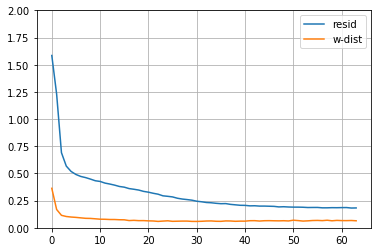

In [107]:
plt.plot(loss_hist_numpy[:,0], loss_hist_numpy[:,2], label = 'resid')
plt.plot(loss_hist_numpy[:,0], loss_hist_numpy[:,3], label = 'w-dist')
plt.legend()
plt.ylim([0,2])
plt.grid()
pass

### test 001
* train mode
* Nwup = Nwup
* Nhrzn = Nwup

In [108]:
Nhrzn_test = Nhrzn
Nwup_test = Nwup

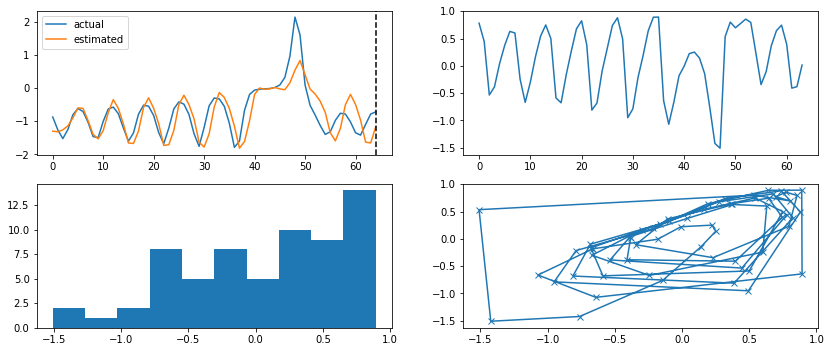

In [109]:
sbf.train()
Ybatch = data_generator.batch(N=Nwup_test+1+Nhrzn_test, Nbatch=1) # (Nwup+1+Nhrzn, 1, Ny)
_, _W, _Yhat = sbf(torch.tensor(Ybatch[:Nwup_test+1,:]), Nhrzn_test)
W = _W.data.numpy() # (Nwup, 1, Nw)
Yhat = _Yhat.data.numpy() # (Nwup+1+Nhrzn, 1, Ny)

plt.figure(figsize=[36/2.57, 15/2.57])
plt.subplot(2,2,1)
plt.plot(Ybatch[:,0,0], '-', label = 'actual')
plt.plot(Yhat[:,0,0], '-', label = 'estimated')
plt.axvline(Nwup_test, color = 'k', linestyle = '--')
plt.legend()
plt.subplot(2,2,2)
plt.plot(W[:,0,:])
plt.subplot(2,2,3)
plt.hist(W[:,0,:])
plt.subplot(2,2,4)
plt.plot(W[:-1,0,0], W[1:,0,0],'-x')
pass

### test 002
* train mode
* Nwup = 0
* Nhrzn = Nwup

In [110]:
Nhrzn_test = Nwup
Nwup_test = 0

In [111]:
sbf.train()
Ybatch = data_generator.batch(N=Nwup_test+1+Nhrzn_test, Nbatch=1) # (Nwup+1+Nhrzn, 1, Ny)
_, _W, _Yhat = sbf(torch.tensor(Ybatch[:Nwup_test+1,:]), Nhrzn_test)
W = _W.data.numpy() # (Nwup, 1, Nw)
Yhat = _Yhat.data.numpy() # (Nwup+1+Nhrzn, 1, Ny)

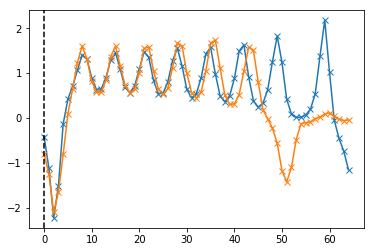

In [112]:
plt.figure()
plt.plot(Ybatch[:,0,0], '-x', label = 'actual')
plt.plot(Yhat[:,0,0], '-x', label = 'estimated')
plt.axvline(Nwup_test, color = 'k', linestyle = '--')

### test 003
* eval model
* Nwup = 0
* Nhrzn = Nwup

In [128]:
Nhrzn_test = 2**6
Nwup_test = 2**6
Nbatch_test = 2**1

In [129]:
Ybatch = data_generator.batch(N=Nwup_test+1+Nhrzn_test, Nbatch=1) # (Nwup+1+Nhrzn, 1, Ny)
Ybatch = np.repeat(Ybatch, Nbatch_test, axis=1)

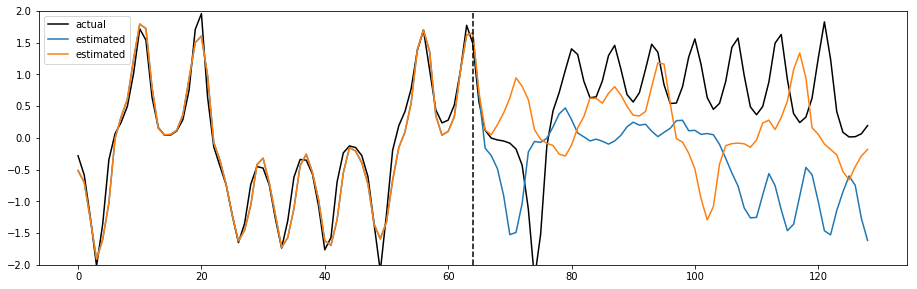

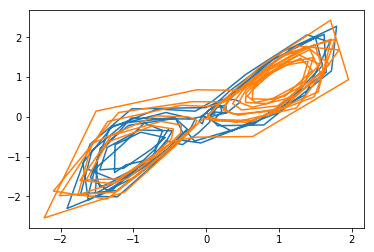

In [132]:
sbf.eval()
_, _W, _Yhat = sbf(torch.tensor(Ybatch[:Nwup_test+1,:]), Nhrzn_test)
W = _W.data.numpy() # (Nwup, *, Nw)
Yhat = _Yhat.data.numpy() # (Nwup+1+Nhrzn, *, Ny)

plt.figure(figsize=[40/2.57, 12/2.57])
plt.plot(Ybatch[:,0,0], '-k', label = 'actual')
plt.plot(Yhat[:,:,0], '-', label = 'estimated')
plt.axvline(Nwup_test, color = 'k', linestyle = '--')
plt.ylim([-2,2])
plt.legend()
plt.figure()
plt.plot(Yhat[:,0,0], Yhat[:,0,1])
plt.plot(Ybatch[:,0,0], Ybatch[:,0,1])

### test 004
* train mode
* Nwup = Nwup
* Nhrzn = 0

cumsum(W) ~ brownian motion?

In [377]:
Nhrzn_test = 0
Nwup_test = Nwup
Nbatch_test = 2**7

In [378]:
sbf.train()
Ybatch = data_generator.batch(N=Nwup_test+1+Nhrzn_test, Nbatch=Nbatch_test) # (Nwup+1+Nhrzn, 1, Ny)
_, _W, _ = sbf(torch.tensor(Ybatch[:Nwup_test+1,:]), Nhrzn_test)
W = _W.data.numpy() # (Nwup, *, Nw)

In [379]:
W_cumsum = np.cumsum(W, axis=0)
var_W_cumsum = np.std(W_cumsum, axis=1)**2 # (Nwup, Nw)

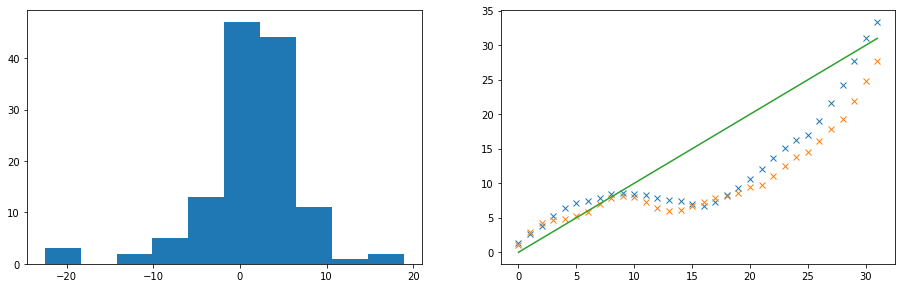

In [380]:
plt.figure(figsize=[40/2.57, 12/2.57])
plt.subplot(1,2,1)
plt.hist(W_cumsum[-1,:,0])
plt.subplot(1,2,2)
plt.plot(var_W_cumsum, 'x')
plt.plot(np.arange(Nwup_test))

(array([ 8.,  9.,  9., 21., 19., 32., 15.,  5.,  7.,  3.]),
 array([-1.6899467 , -1.3219016 , -0.9538566 , -0.5858115 , -0.21776648,
         0.15027857,  0.5183236 ,  0.88636863,  1.2544137 ,  1.6224587 ,
         1.9905038 ], dtype=float32),
 <a list of 10 Patch objects>)

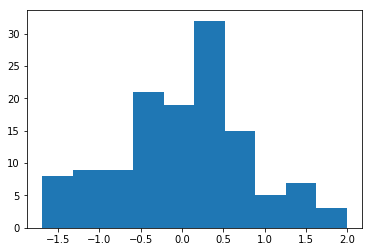

In [381]:
plt.hist(W[-1,:,0])

In [ ]:
jkkkkkk